In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchviz import make_dot
import time
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### Загрузка данных

Files already downloaded and verified
Files already downloaded and verified
Метки классов: automobile horse cat   deer  frog  automobile horse horse cat   horse frog  ship  dog   bird  horse cat   bird  frog  airplane ship  bird  ship  truck truck automobile frog  truck automobile frog  frog  dog   ship  ship  dog   frog  cat   deer  truck deer  deer  deer  cat   bird  bird  automobile airplane dog   horse truck ship 


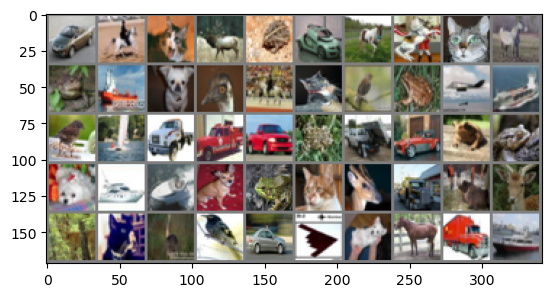

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Функция для отображения изображений и меток классов
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Получение случайного пакета обучающих данных
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Отображение пакета изображений и меток
imshow(torchvision.utils.make_grid(images, nrow=10))
print('Метки классов:', ' '.join(f'{class_names[labels[j]]:5s}' for j in range(50)))

### Построение архитектуры сверточной сети

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, 3)
        self.conv2 = torch.nn.Conv2d(32, 64, 3)
        self.conv3 = torch.nn.Conv2d(64, 128, 3)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(32 * 4 * 4, 64)
        self.fc2 = torch.nn.Linear(64, 128)
        self.fc3 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = self.pool(torch.nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 32 * 4 * 4)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.nn.functional.log_softmax(x, dim=1)

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


### Обучение модели

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
num_epochs = 10

start_training_time = time.time()
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    end_time = time.time()
    epoch_time = end_time - start_time

    accuracy = 100 * correct / total

    print(f'Эпоха {epoch + 1}, Точность: {accuracy:.2f}%, Время: {epoch_time:.2f} сек.')

end_training_time = time.time()
total_training_time = end_training_time - start_training_time

print(f'Обучение завершено. Общее время обучения: {total_training_time:.2f} сек.')

Эпоха 1, Точность: 29.82%, Время: 17.97 сек.
Эпоха 2, Точность: 51.97%, Время: 17.52 сек.
Эпоха 3, Точность: 62.47%, Время: 17.91 сек.
Эпоха 4, Точность: 67.88%, Время: 17.89 сек.
Эпоха 5, Точность: 72.08%, Время: 17.90 сек.
Эпоха 6, Точность: 75.15%, Время: 24.46 сек.
Эпоха 7, Точность: 77.46%, Время: 18.41 сек.
Эпоха 8, Точность: 79.82%, Время: 17.49 сек.
Эпоха 9, Точность: 81.63%, Время: 17.43 сек.
Эпоха 10, Точность: 83.21%, Время: 17.42 сек.
Обучение завершено. Общее время обучения: 184.41 сек.


### Тестирование модели

In [5]:
net.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total

print(f'Точность на тестовом наборе данных: {test_accuracy:.2f}%')

Точность на тестовом наборе данных: 72.95%
